<a href="https://colab.research.google.com/github/dimaszuda/LFP_Battery_SoC_Prediction/blob/main/Projek_Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [255]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [256]:
dataframe = pd.ExcelFile("ChargeDischarge 18650.xlsx").parse('record')

In [257]:
dataframe.head(2)

,CycleID,Step ID,Step Type,Rate_C,Record ID,C_Rate,Time(h:m:s:ms:us),Voltage(V),Current(mA),Cap(mAh),Energy(mWh),Power(mW),DCIR(mO),Realtime,Filled Capacity,SoC (%)
0,1.0,1.0,CC_Chg,0.503168,1.0,0.503168,0:00:00:000.000,3.32923,899.479,0.00000,0.00000,2994.58,0.0,2022-04-18 14:40:44:000.000,0.000000,0.000
1,1.0,1.0,CC_Chg,0.503113,2.0,0.503113,0:00:01:000.000,3.33115,899.380,0.24983,0.83221,2995.97,0.0,2022-04-18 14:40:45:000.000,0.249828,0.014


In [258]:
dataframe.drop(dataframe.columns[[1, 3,  4, 6, 10, 11, 12, 13, 14]], axis=1, inplace=True)

In [259]:
dataframe = dataframe.rename(columns= {'Step Type' : 'Step_Type'})

In [260]:
dataframe.isna().sum()

CycleID        829382
Step_Type      829382
C_Rate         829382
Voltage(V)     829382
Current(mA)    829382
Cap(mAh)       829382
SoC (%)        830285
dtype: int64

In [261]:
dataframe = dataframe.dropna()

In [262]:
dataframe = dataframe.drop_duplicates()

In [263]:
dataframe.head(2)

,CycleID,Step_Type,C_Rate,Voltage(V),Current(mA),Cap(mAh),SoC (%)
0,1.0,CC_Chg,0.503168,3.32923,899.479,0.00000,0.000
1,1.0,CC_Chg,0.503113,3.33115,899.380,0.24983,0.014


In [264]:
def outlier(data, column):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1
  lwr = Q1 - (1.5*IQR)
  upr = Q3 + (1.5*IQR)
  return lwr, upr

In [265]:
font = {'family': 'serif',
        'color': 'darkred',
        'weight': 'bold'
        }

In [266]:
def plot_outlier(data, column):
  fig, ax = plt.subplots(figsize=(6, 4))
  ax.set_title('Data Outlier')
  ax.boxplot(data)
  ax.set_aspect(1.5, anchor='C')
  ax.set_xticks([y+1 for y in range(len(data))], labels=['Original Data', 'removed outlier', 'fully removed'])
  ax.set_xlabel(column, fontdict=font)
  plt.show()

In [267]:
lwr, upr = outlier(dataframe, 'Voltage(V)')
dataframe1 = dataframe[~((dataframe['Voltage(V)'] < lwr) | (dataframe['Voltage(V)'] > upr))]

In [268]:
lwr, upr = outlier(dataframe1, 'Voltage(V)')
dataframe2 = dataframe1[~((dataframe1['Voltage(V)'] < lwr) | (dataframe1['Voltage(V)'] > upr))]

In [269]:
lwr, upr = outlier(dataframe2, 'Voltage(V)')
dataframe3 = dataframe2[~((dataframe2['Voltage(V)'] < lwr) | (dataframe2['Voltage(V)'] > upr))]

In [270]:
df1 = dataframe1['Voltage(V)'].dropna()
df2 = dataframe2['Voltage(V)'].dropna()
df3 = dataframe3['Voltage(V)'].dropna()
sample = [df1, df2, df3]

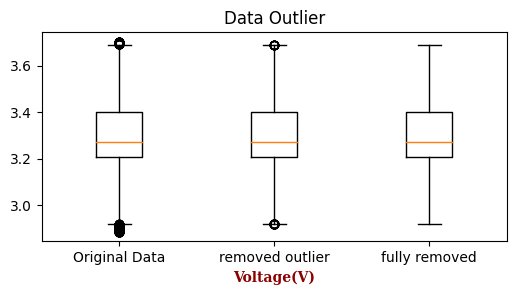

In [271]:
plot_outlier(sample, 'Voltage(V)')

In [272]:
charge = dataframe3[(dataframe3['Step_Type'] == 'CC_Chg')]

In [273]:
discharge = dataframe3[(dataframe3['Step_Type'] == 'CC_DChg')]

In [274]:
cc_dc = charge.append(discharge)

<ipython-input-274-b48ebb0d9bb2>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_dc = charge.append(discharge)


In [275]:
c_0_5 = cc_dc[(cc_dc['C_Rate']<1.000000)]
c_1 = cc_dc[(cc_dc['C_Rate']>1.000000) & (cc_dc['C_Rate']<2.000000)]
c_2 = cc_dc[(cc_dc['C_Rate']>2.000000) & (cc_dc['C_Rate']<3.000000)]
c_3 = cc_dc[(cc_dc['C_Rate']>3.000000)]

In [276]:
cc_dc = cc_dc[(cc_dc['C_Rate']>1.000000)]

In [277]:
columns = ['CycleID',
           'Current(mA)',
           'Voltage(V)',
           'Cap(mAh)']

In [278]:
X_train = cc_dc[columns]
y_train = cc_dc['SoC (%)'].values.reshape(-1,1)
X_test = c_0_5[columns]
y_test = c_0_5['SoC (%)'].values.reshape(-1,1)

In [279]:
scaler = MinMaxScaler()

In [280]:
df_f = scaler.fit_transform(X_train)
dt_f = scaler.fit_transform(X_test)
X_train = pd.DataFrame(df_f, columns=columns)
X_test = pd.DataFrame(dt_f, columns=columns)

In [281]:
df_l = scaler.fit_transform(y_train)
dt_l = scaler.fit_transform(y_test)
y_train = pd.DataFrame(df_l, columns=['SoC (%)'])
y_test = pd.DataFrame(dt_l, columns=['SoC (%)'])

In [282]:
def build_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(4)),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  optimizer = tf.keras.optimizers.Adamax(0.0001)
  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [283]:
model = build_model()

In [284]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                160       
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [285]:
data_train = model.fit(X_train, y_train, epochs=1400, batch_size=1000, shuffle=False, validation_split=0.2)

Epoch 1/1400
50/50 [==============================] - 1s 7ms/step - loss: 0.2683 - mse: 0.1011 - val_loss: 0.2429 - val_mse: 0.0823
Epoch 2/1400
50/50 [==============================] - 0s 5ms/step - loss: 0.2650 - mse: 0.0982 - val_loss: 0.2427 - val_mse: 0.0819
Epoch 3/1400
50/50 [==============================] - 0s 3ms/step - loss: 0.2624 - mse: 0.0958 - val_loss: 0.2424 - val_mse: 0.0815
Epoch 4/1400
50/50 [==============================] - 0s 3ms/step - loss: 0.2601 - mse: 0.0937 - val_loss: 0.2421 - val_mse: 0.0812
Epoch 5/1400
50/50 [==============================] - 0s 3ms/step - loss: 0.2581 - mse: 0.0920 - val_loss: 0.2417 - val_mse: 0.0808
Epoch 6/1400
50/50 [==============================] - 0s 4ms/step - loss: 0.2563 - mse: 0.0904 - val_loss: 0.2414 - val_mse: 0.0805
Epoch 7/1400
50/50 [==============================] - 0s 4ms/step - loss: 0.2546 - mse: 0.0889 - val_loss: 0.2410 - val_mse: 0.0802
Epoch 8/1400
50/50 [==============================] - 0s 3ms/step - loss: 0.

In [286]:
def plot_history(history, title, xlabel, ylabel):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], 'r')
  plt.plot(history.history['mse'], 'b')
  plt.plot(history.history['val_loss'], 'g')
  plt.plot(history.history['val_mse'], 'y')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(['mae', 'mse', 'val_mae', 'val_mse'], loc='upper right')
  plt.show()

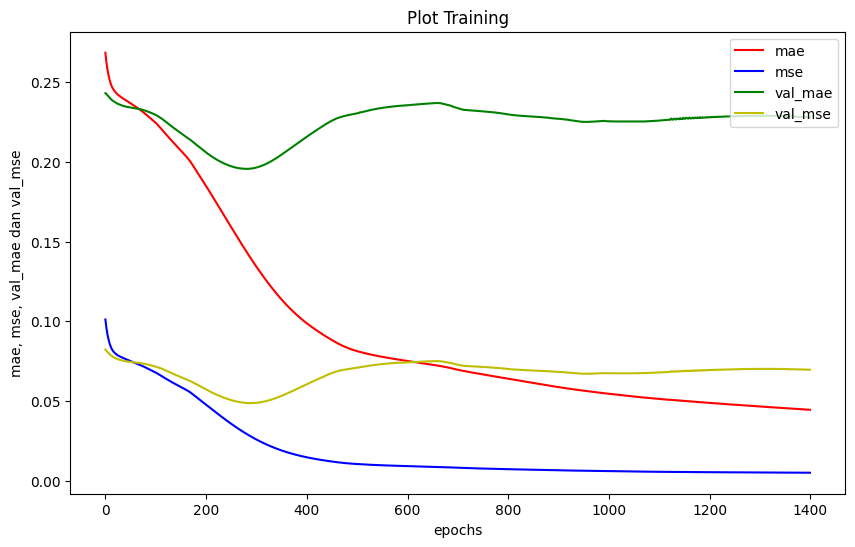

In [287]:
plot_history(data_train, 'Plot Training', 'epochs', 'mae, mse, val_mae dan val_mse')

In [288]:
data_test = model.evaluate(X_test, y_test)

4269/4269 [==============================] - 7s 2ms/step - loss: 0.3387 - mse: 0.1649


In [295]:
data_prediksi = model.predict(X_test)

4269/4269 [==============================] - 7s 2ms/step


In [296]:
predicted_data = pd.DataFrame(data_prediksi, columns=['Predicted'])

In [ ]:
Voltage = cc_dc['Voltage(V)']

In [297]:
data_Voltage = pd.DataFrame(Voltage, columns=['Voltage(V)'])

In [305]:
Voltage

72100     2.92268
72101     2.92984
72102     2.93549
72103     2.94231
72104     2.94631
           ...   
145363    2.92746
145364    2.92629
145365    2.92413
145366    2.92255
145367    2.92030
Name: Voltage(V), Length: 62393, dtype: float64

In [298]:
predicted_SoC = scaler.inverse_transform(predicted_data)

In [299]:
def plot_prediksi(step, voltage, judul, sb_x, sb_y):
  plt.figure(figsize=(15, 6))
  plt.scatter(step, voltage, c='#fc0303')
  plt.rcParams['lines.linewidth'] == 43
  plt.rcParams['lines.linestyle'] == '-'
  plt.rcParams['lines.markersize']**0.5
  plt.title(judul)
  plt.xlabel(sb_x)
  plt.ylabel(sb_y)
  plt.show()
  return plt

ValueError: ignored

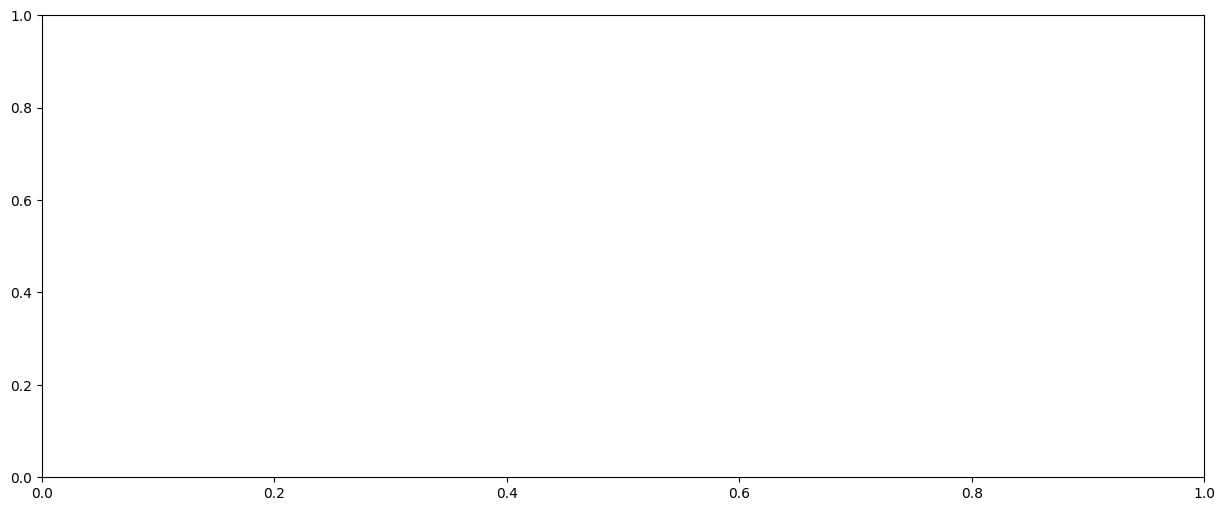

In [300]:
plot_prediksi(predicted_SoC, data_Voltage, 'SoC', 'SoC Prediksi', 'Voltage(V)')